In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


**1.Importing Modules**

In [2]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import eli5
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score
from eli5.sklearn import PermutationImportance
from pdpbox import pdp,get_dataset,info_plots
from sklearn.feature_selection import RFECV
from scipy.stats import norm, skew
from scipy.optimize import curve_fit
import shap

**2.Importing data and taking overview of it**

In [3]:
data=pd.read_csv("../input/heart.csv")

We can see that rest blood pressure (trestbps) ,cholesterol (chol), max heart rate (thalach) and exercise induced ST depression (oldpeak) have continuous forms while all other features have discrete form.

In [4]:
data.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
258,62,0,0,150,244,0,1,154,1,1.4,1,0,2,0
295,63,1,0,140,187,0,0,144,1,4.0,2,2,3,0
259,38,1,3,120,231,0,1,182,1,3.8,1,0,3,0
289,55,0,0,128,205,0,2,130,1,2.0,1,1,3,0
137,62,1,1,128,208,1,0,140,0,0.0,2,0,2,1


In [5]:
print(data.shape)

(303, 14)


We see that there are no null values. 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


**3. How is the distribution of continuous features?**

We see that except for distribution of exercise induced ST depression (oldpeak), all other continuous features have normal distribution to good extent

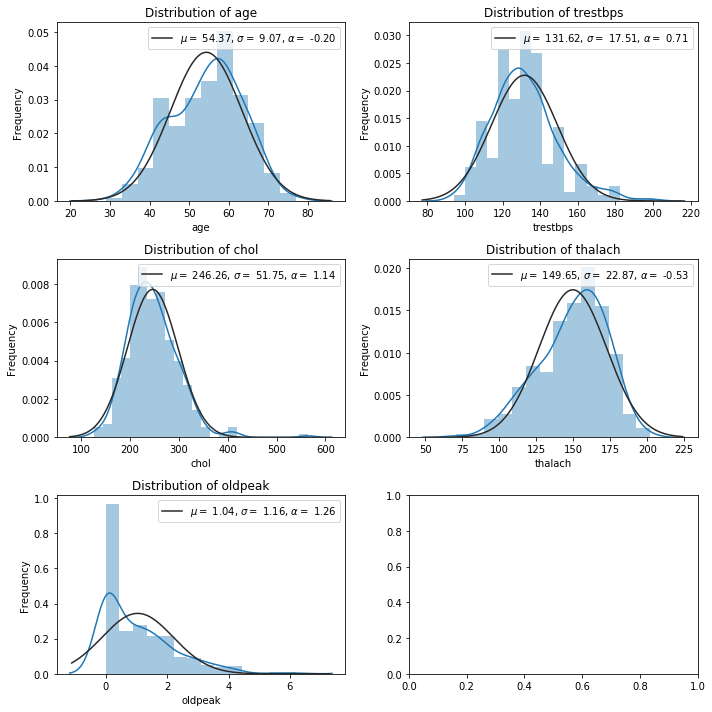

In [7]:
continuous=['age','trestbps','chol','thalach','oldpeak']

f,ax=plt.subplots(3,2,figsize=(10,10))
for i,feature in enumerate(continuous):
    (mu,sigma)=norm.fit(data[feature])
    alpha=skew(data[feature])
    sns.distplot(data[feature],fit=norm,ax=ax[i//2][i%2])
    ax[i//2][i%2].set_title('Distribution of {}'.format(feature))
    ax[i//2][i%2].legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}, $\\alpha=$ {:.2f}'.format(mu,sigma,alpha)],loc='best')
    ax[i//2][i%2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

I transformed the age feature in bins as per intuition. This gives us an idea of how many people are young while how many are aged.. though it is subjective xD

We see that there are more number of aged people than younger people

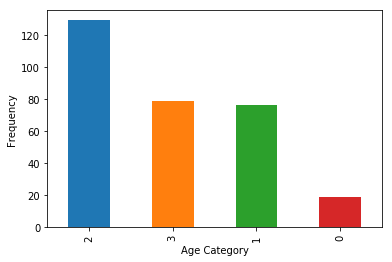

In [8]:
bins=[28,40,50,60,80]
names=['Young Adult','Adult','Adult 2','Old']
data['age']=pd.cut(data['age'],bins=bins,labels=names)
age_map={'Young Adult':'0','Adult':'1','Adult 2':'2','Old':'3'}
data['age']=data['age'].map(age_map)
data['age']=data['age'].astype('int64')
data['age'].value_counts().plot.bar()
plt.xlabel('Age Category')
plt.ylabel('Frequency')
plt.show()

**4. How do the continuous features vary with age?**


As expected, we see that trestbps, chol and oldpeak increase with age, while thalach (max heart rate achieved) decreases with age.

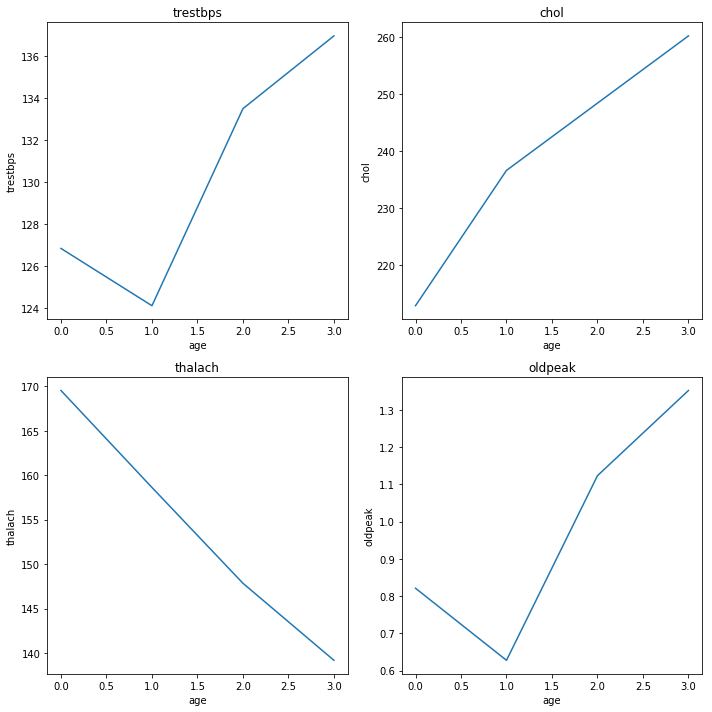

In [9]:
f,ax=plt.subplots(2,2,figsize=(10,10))
continuous.remove('age')
for i,feature in enumerate(continuous):
    df=data.groupby('age')[feature].mean().reset_index()
    sns.lineplot(data=df,y=df[feature],x=df['age'],ax=ax[i//2][i%2])
    ax[i//2][i%2].set_title('{}'.format(feature))
    
plt.tight_layout()
plt.show()

**5. How do the continuous features vary with target ?**

1 in target refers to presence of heart disease. We see that trestbps,chol and oldpeak of people suffering from heart disease is lesser than 0 target people while thalach is more than 0 target people. Intuitionally, I expected trestbps, chol and oldpeak of 1 target people to be higher than 0 target people. I am not an expert in medical field, so maybe I was wrong.

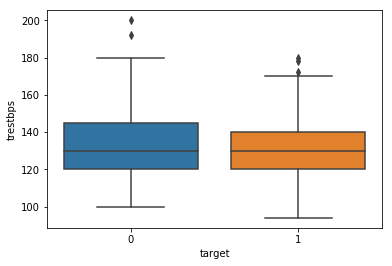

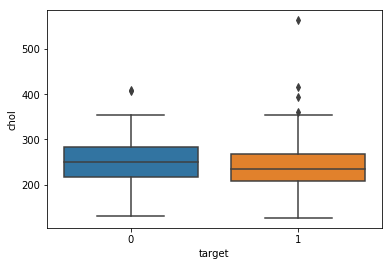

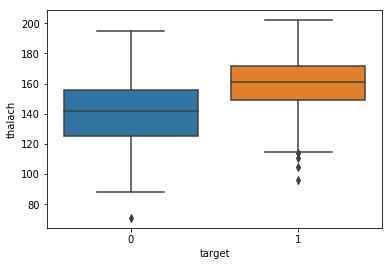

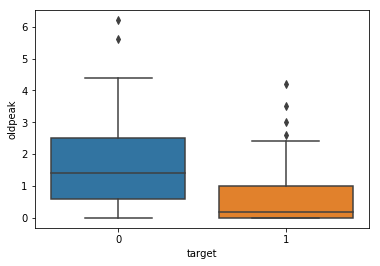

In [10]:
for feature in continuous:
    sns.boxplot(x='target',y=feature,data=data)
    plt.show()

**6. How do the discrete features vary with target ?**


In case of age vs target, proportion of people suffering from heart disease in that particular age group decreases with age. Again, this goes against my intuition ! In case of sex vs target, greater proportion of females have heart disease than males. Greater chest pain correlates with higher probability of having heart disease. 

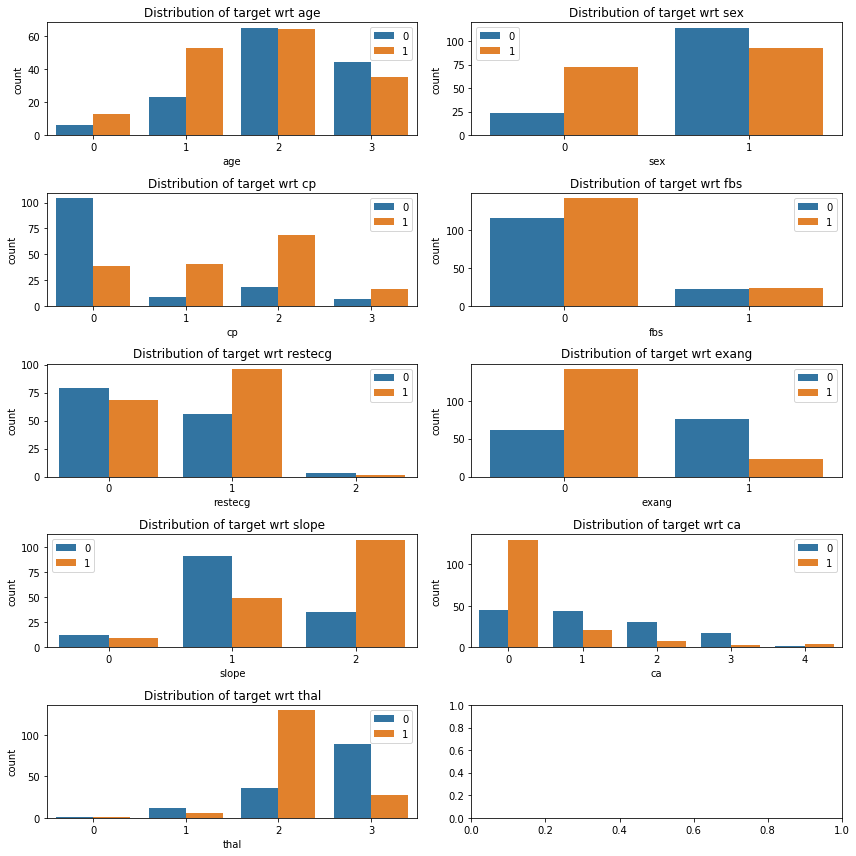

In [11]:
f,ax=plt.subplots(5,2,figsize=(12,12))

for i,feature in enumerate(['age','sex','cp','fbs','restecg','exang','slope','ca','thal']):
    sns.countplot(x=feature,data=data,hue='target',ax=ax[i//2,i%2])
    ax[i//2,i%2].set_title('Distribution of target wrt {}'.format(feature))
    ax[i//2,i%2].legend(loc='best')

plt.tight_layout()
plt.show()

7. Splitting and Preprocessing

Making the continuous features normally distributed. 

In [12]:
X=data.drop('target',axis=1)
Y=data['target']

train_X,test_X,train_y,test_y=train_test_split(X,Y,random_state=1,test_size=0.2)

ss=StandardScaler()

train_X[continuous]=ss.fit_transform(train_X[continuous])
test_X[continuous]=ss.transform(test_X[continuous])
    

**8. Feature Importance**

Thus we see that if the decisions were taken by the classifier by ignoring chest pain, then large number of them go haywire. So it has the most feature importance. 

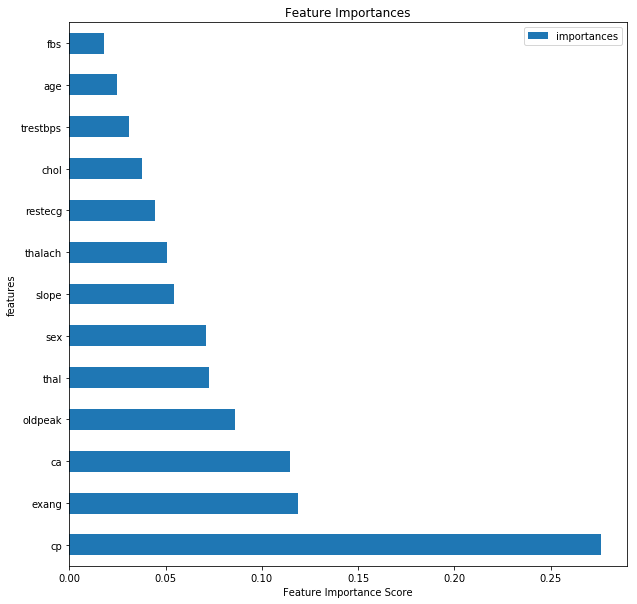

In [13]:
my_model=xgb.XGBClassifier(n_estimators=100).fit(train_X,train_y)

feat_imp=pd.DataFrame({'importances':my_model.feature_importances_})
feat_imp['features']=train_X.columns
feat_imp=feat_imp.sort_values(by='importances',ascending=False)


feat_imp=feat_imp.set_index('features')
feat_imp.plot.barh(title='Feature Importances',figsize=(10,10))
plt.xlabel('Feature Importance Score')
plt.show()

**9. Permutation Importance**

If the values of thal are shuffled in test_X while keeping all other features as it is, and then prediction was done then it has most impact than the shuffling of some other feature. 

In [14]:
perm=PermutationImportance(my_model,random_state=1).fit(test_X,test_y)
eli5.show_weights(perm,feature_names=test_X.columns.tolist())

Weight,Feature
0.0525 ± 0.0435,thal
0.0492 ± 0.0776,thalach
0.0426 ± 0.0608,ca
0.0164 ± 0.0207,slope
0.0131 ± 0.0245,sex
0.0131 ± 0.0482,trestbps
0.0066 ± 0.0161,age
0.0066 ± 0.0445,restecg
0.0066 ± 0.0445,chol
0.0066 ± 0.0491,oldpeak


**Correlation Matrix**


There is no substantial correlation amongst the features tmeselves. 

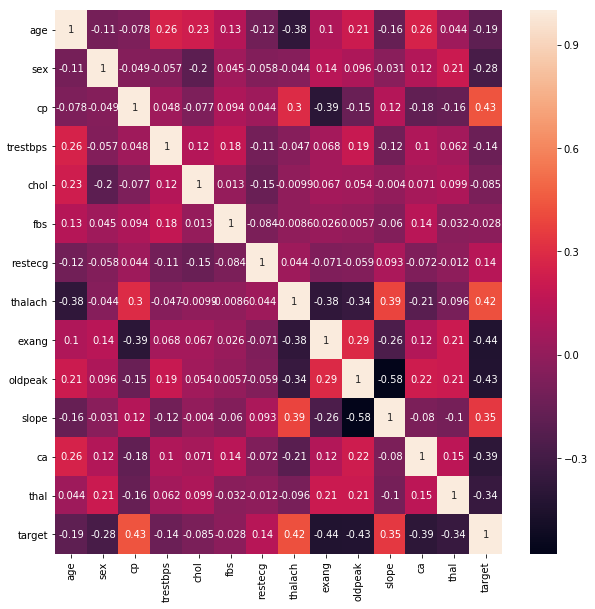

In [15]:
corr=data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)
plt.show()


**Partial Dependence Plots of all features**

In each plot, we see how the probability of having some target value (0 or 1) changes as the feature under construction increases its value. 

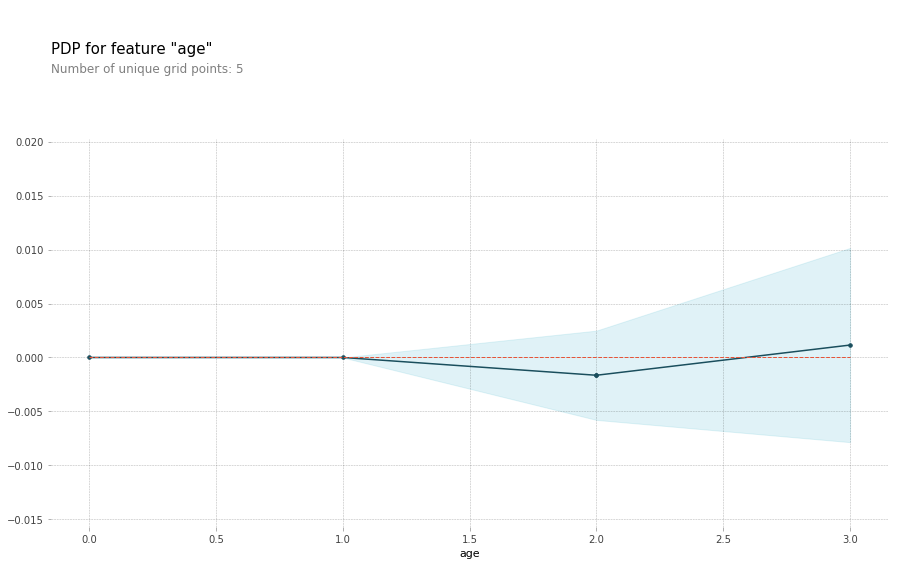

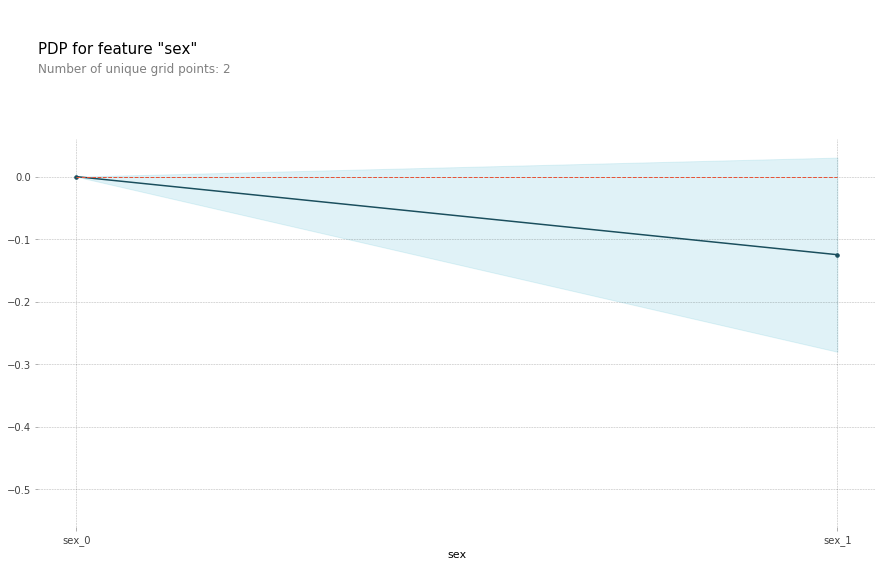

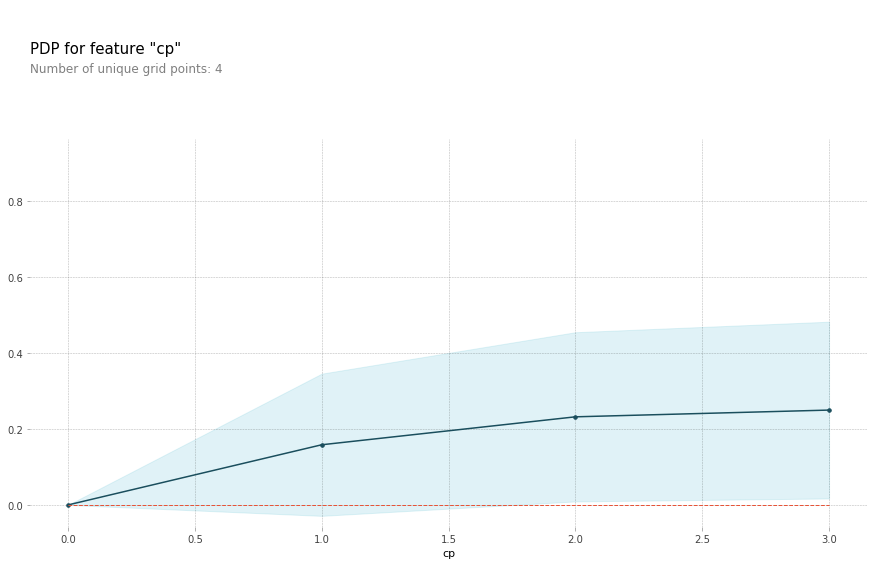

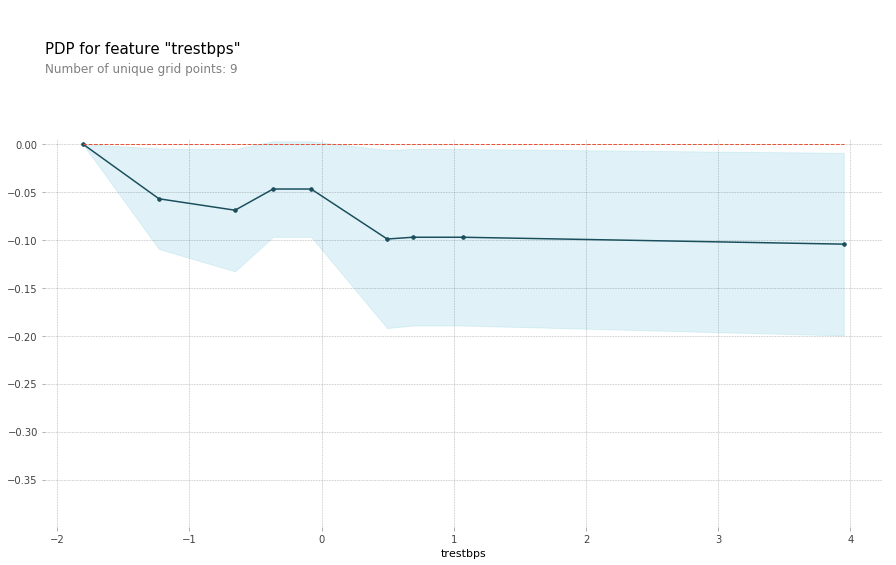

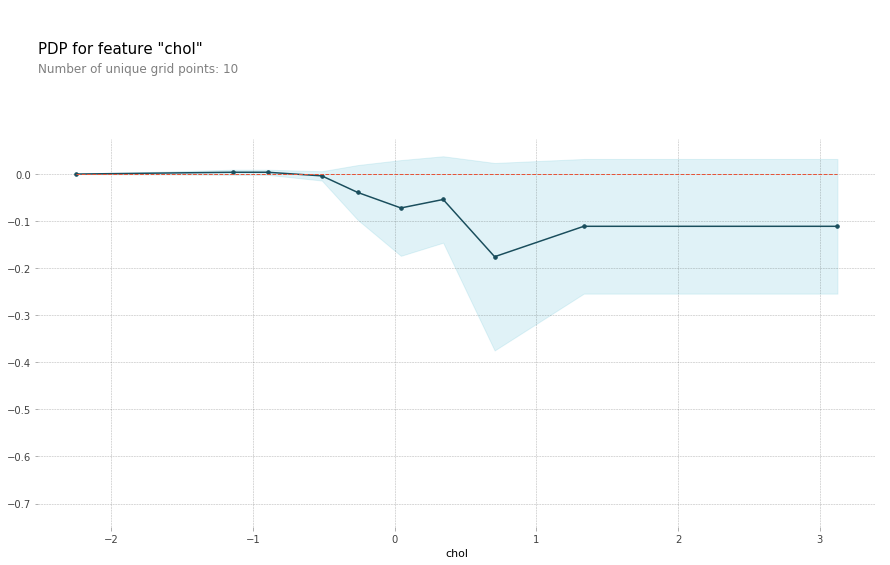

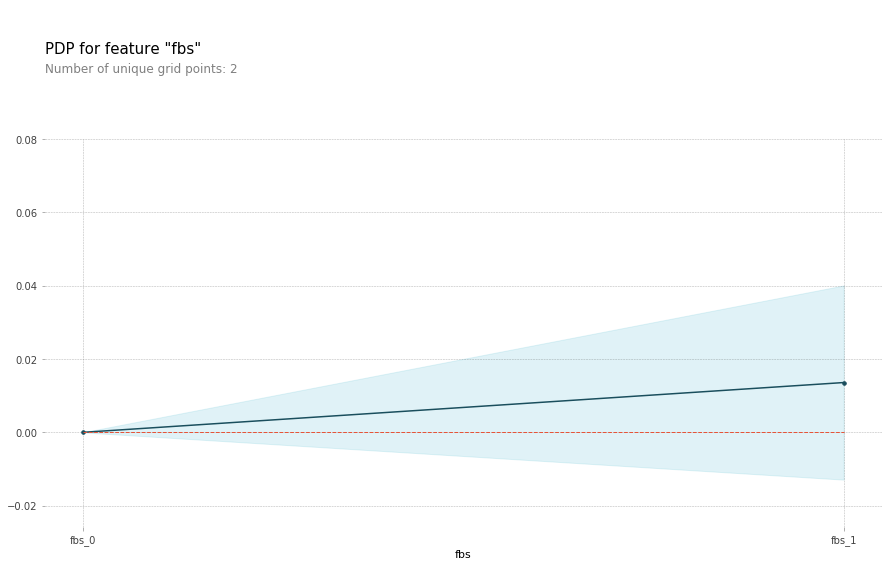

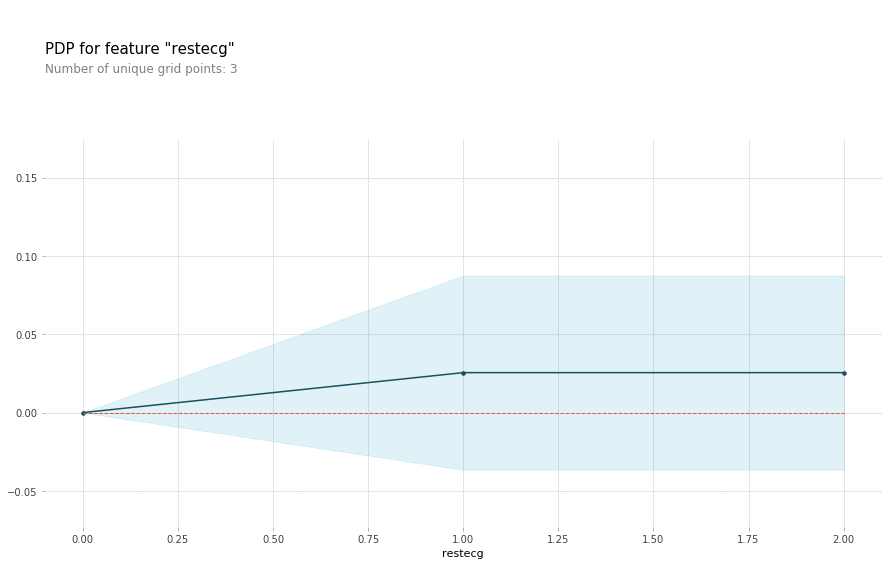

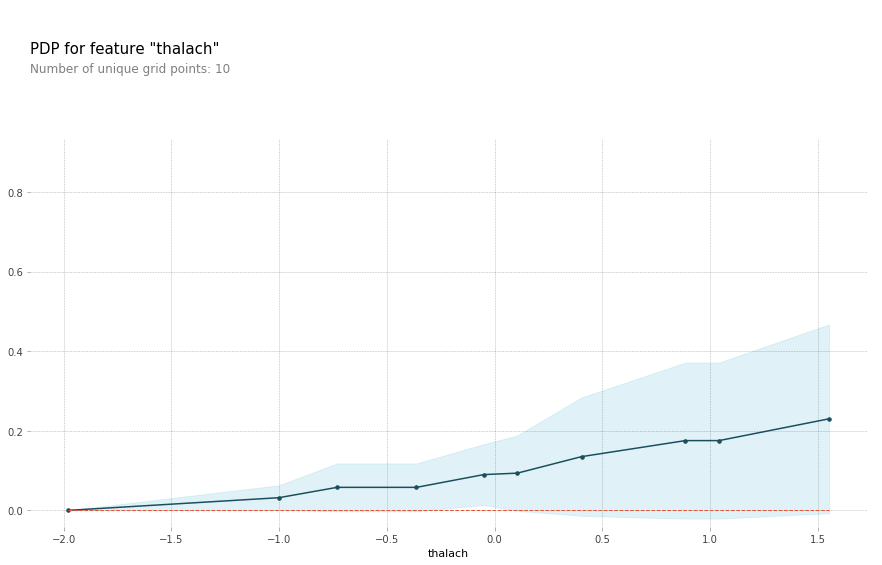

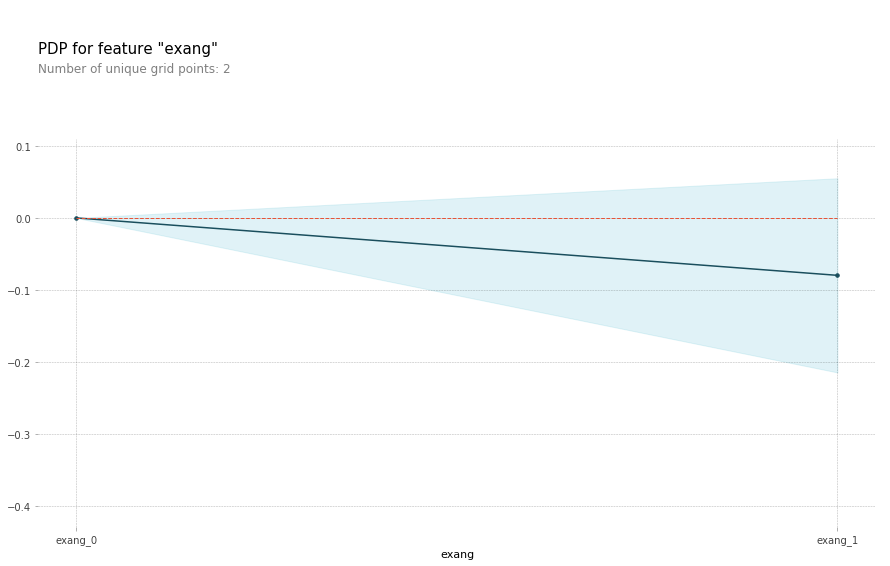

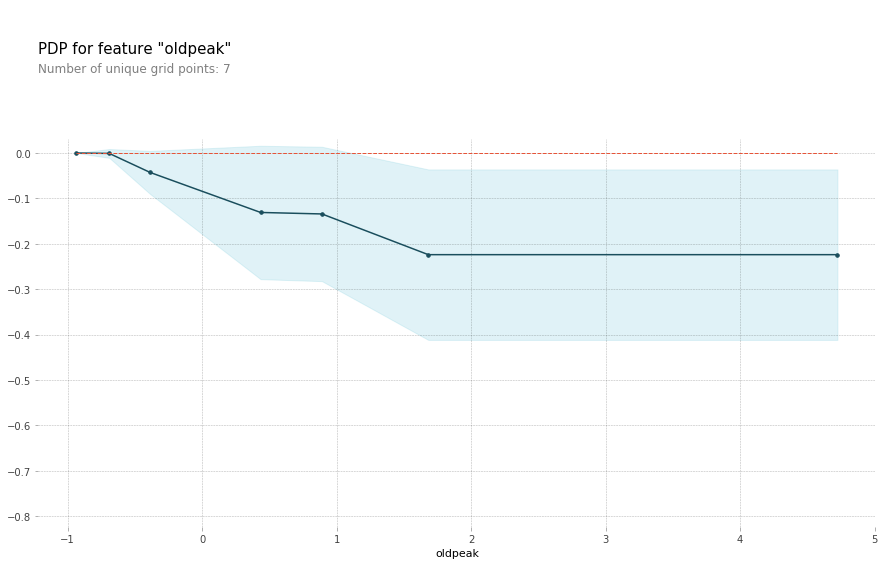

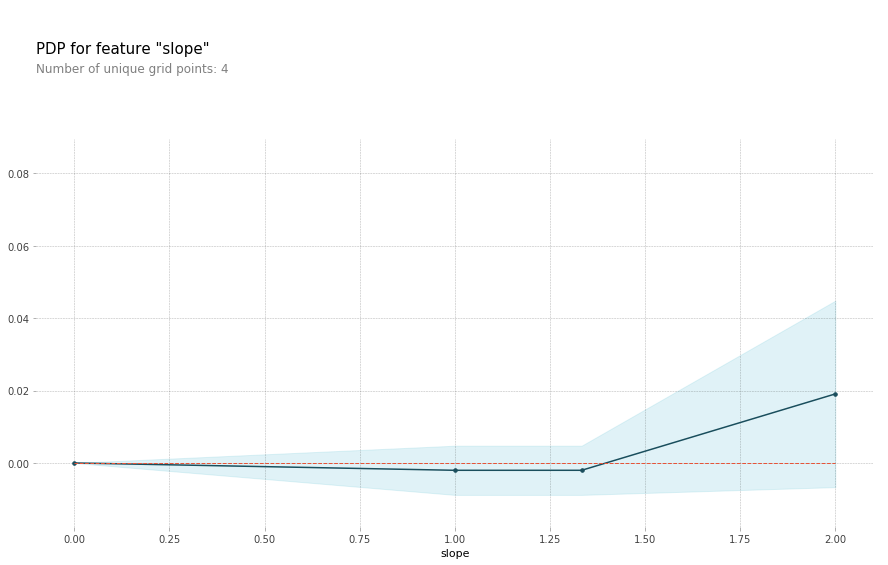

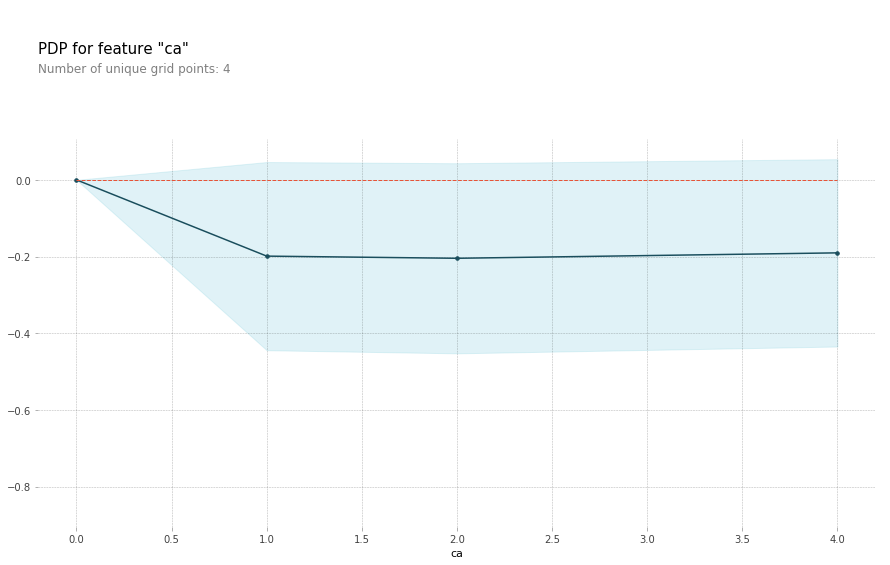

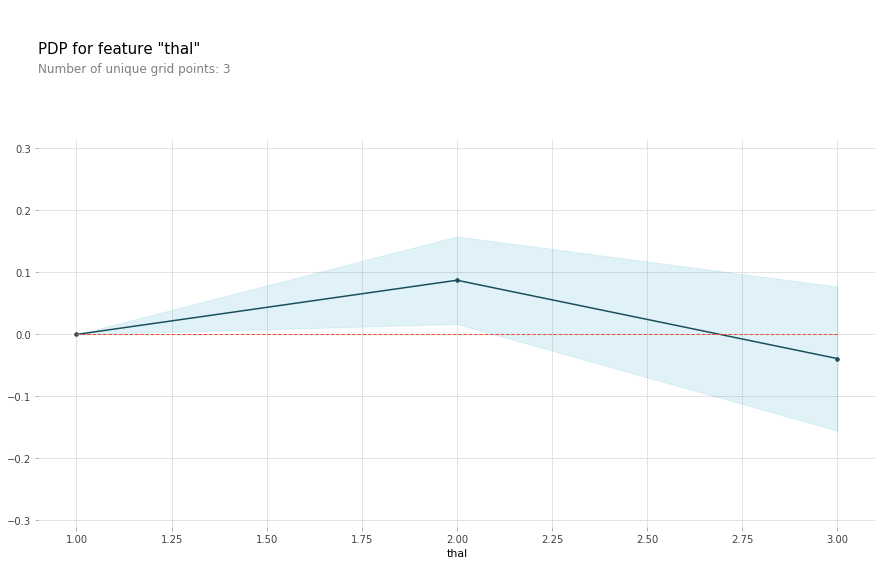

In [16]:
for features in test_X.columns:
    partial_graph=pdp.pdp_isolate(model=my_model,dataset=test_X,model_features=test_X.columns,feature=features)
    pdp.pdp_plot(partial_graph,features)
    plt.show()

**SHAP values**

We see how much impact cp,ca, oldpeak have on probability of having either target values. Negative impact refers that probability of having 0 target value increases while positive impact refers to probability of having heart disease increases.

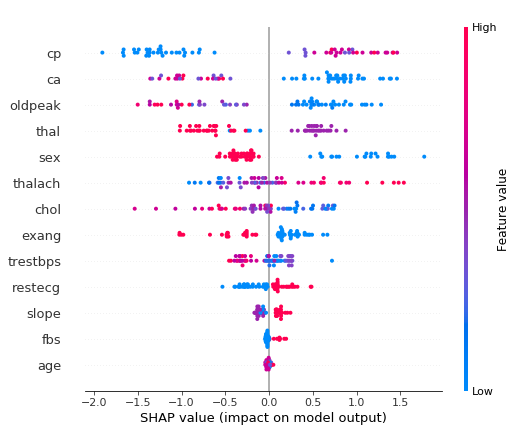

In [17]:
explainer=shap.TreeExplainer(my_model)
shap_values=explainer.shap_values(test_X)
shap.summary_plot(shap_values,test_X)

In [18]:
pred=my_model.predict(test_X)

print('Accuracy:',accuracy_score(test_y,pred))

Accuracy: 0.7704918032786885


**Recursive Feature Elimination with Cross Validation**

We see that the best fit is the one with 12 features. The fbs feature is removed. Even in case of permutation importance, permuting the values of fbs had no effect on prediction. Even in feature importances, fbs has least importance.

In [19]:
rfc=RandomForestClassifier(n_estimators=100)
acc=make_scorer(accuracy_score)
rfecv=RFECV(rfc,cv=5,scoring=acc,step=1)
rfecv=rfecv.fit(train_X,train_y)

print('Optimal number of features:',rfecv.n_features_)
print('\nBest features:',train_X.columns[rfecv.support_])

Optimal number of features: 13

Best features: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')


In [20]:
train_X1=rfecv.transform(train_X)
test_X1=rfecv.transform(test_X)

rfc_1=RandomForestClassifier(n_estimators=100,random_state=2).fit(train_X1,train_y)
pred_1=rfc_1.predict(test_X1)
print('Accuracy:',accuracy_score(test_y,pred_1))

Accuracy: 0.7704918032786885


**How Grid Score varies with number of features? **

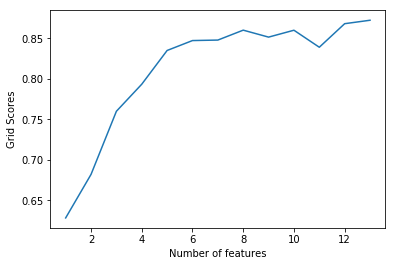

In [21]:
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Grid Scores')
plt.show()